In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import ast
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [2]:
df_raw = pd.read_csv('glassdoor_jobs_cleaned.csv')

In [3]:
pd.set_option('display.max_rows', None)
df_raw.head()

,Job Title,Job Description,Location,Headquarters,seniority,company_name,location_city,hq_city,ratings,avg_salary,...,avg_revenue,min_size,max_size,avg_size,languages,ownership,industry,sector,competitors,founded
0,Data Scientist - ZISHI Adaptive,"Company Description\n\nIn just over 15 years, ...","Bromley, England","London, United Kingdom",junior,OSTC UK,Bromley,London,3.8,45000.0,...,3.750000e+07,201,500,350.5,"{'python': 1, 'excel': 1, 'sql': 1, 'aws': 1, ...",private,['Brokerage Services'],['Finance'],"['J.P. Morgan', 'XTB', 'Mandara']",1999
1,"Data Scientist, Digital",The details\n\n\nNewton is a high growth and s...,"Wideopen, England","Oxford, United Kingdom",junior,Newton Europe,Wideopen,Oxford,3.9,45000.0,...,7.500000e+07,201,500,350.5,"{'python': 1, 'excel': 0, 'sql': 1, 'aws': 0, ...",private,['Consulting'],['Business Services'],['-1'],2001
2,Data Scientist,Imagine introducing the next generation of tec...,"London, England","London, United Kingdom",junior,G-Research,London,London,4.8,45000.0,...,-1.000000e+00,501,1000,750.5,"{'python': 1, 'excel': 0, 'sql': 1, 'aws': 0, ...",private,"['Computer Hardware', 'Software']",['Information Technology'],['-1'],2001
3,Data Scientist,"Data Scientist\nCambridge UK, Gaithersburg, Go...","Cambridge, England","Cambridge, United Kingdom",junior,AstraZeneca,Cambridge,Cambridge,4.0,45000.0,...,7.500000e+09,10000,10000,10000.0,"{'python': 0, 'excel': 0, 'sql': 0, 'aws': 0, ...",public,"['Biotech', 'Pharmaceuticals']","['Biotech', 'Pharmaceuticals']","['Roche', 'GlaxoSmithKline', 'Novartis']",1913
4,Senior Data Scientist,About Us\n\nWe want to help small businesses w...,"London, England","London, United Kingdom",senior,Funding Circle UK,London,London,3.4,45000.0,...,7.500000e+07,501,1000,750.5,"{'python': 1, 'excel': 1, 'sql': 1, 'aws': 0, ...",private,['Lending'],['Finance'],"['LendingClub', 'OnDeck', 'Bond Street']",2010


In [4]:
i = 0
for col in list(df_raw.columns):
    print(i+1, col)
    i += 1

1 Job Title
2 Job Description
3 Location
4 Headquarters
5 seniority
6 company_name
7 location_city
8 hq_city
9 ratings
10 avg_salary
11 min_salary
12 max_salary
13 min_revenue
14 max_revenue
15 avg_revenue
16 min_size
17 max_size
18 avg_size
19 languages
20 ownership
21 industry
22 sector
23 competitors
24 founded


In [5]:
# Create job role column
df = df_raw.copy()
def get_role(title):
    if "intern" in title.lower():
        return "intern"
    elif "research" in title.lower():
        return 'research'
    elif "analyst" in title.lower():
        return 'analyst'
    elif "machine learning" in title.lower() or "deep learning" in title.lower():
        return 'mle'
    elif "data engineer" in title.lower():
        return 'de'
    else:
        return 'ds'

df["role"] = df["Job Title"].apply(lambda x: get_role(x))
df.role.head()

0    ds
1    ds
2    ds
3    ds
4    ds
Name: role, dtype: object

In [6]:
def language_present(x):
    Languages = ["python","excel","sql",
                 "aws","spark","hadoop",
                 "java "," r ","tensorflow",
                 "matlab"]
    y = []
    x = ast.literal_eval(x)
    for l in Languages:
        if x[l]!=0:
            y.append(l)
    return y

In [7]:
df["competitors"] = df["competitors"].apply(lambda x: ast.literal_eval(x))
df["languages"] = df["languages"].apply(lambda x: language_present(x))
df["industry"] = df["industry"].apply(lambda x: ast.literal_eval(x))
df["sector"] = df["sector"].apply(lambda x: ast.literal_eval(x))

In [8]:
# Remove England, United kingdom, briton from location
def rm_contries(location):
    unwanted = ["uk", "england", "united kingdom"]
    if location.lower() in unwanted:
        return "-1"
    else:
        return location
    
df.location_city = df.location_city.apply(lambda x: rm_contries(x))

In [9]:
# Competitors count column
df["num_comp"] = df["competitors"].apply(lambda x: 0 if x[0] == '-1' else len(x))

In [10]:
# number of languages in each job
df["num_languages"] = df["languages"].apply(lambda x: len(x))

In [11]:
# Create company age column
df["age"] = df["founded"].apply(lambda x: -1 if x == -1 else 2020 - int(x))

In [12]:
# Remove newline character form job description field
df["Job Description"] = df["Job Description"].apply(lambda x: x.replace("\n", ""))

In [13]:
# Job discription length
df["description_len"] = df["Job Description"].apply(lambda x: len(x))

In [14]:
df.describe()

,ratings,avg_salary,min_salary,max_salary,min_revenue,max_revenue,avg_revenue,min_size,max_size,avg_size,founded,num_comp,num_languages,age,description_len
count,1300.000000,1300.000000,1300.000000,1300.000000,1.300000e+03,1.300000e+03,1.300000e+03,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000
mean,2.860231,49523.076923,37933.076923,61113.076923,1.284324e+09,5.647386e+09,3.465855e+09,3189.743846,4273.475385,3731.609615,1444.019231,0.744615,2.202308,37.817692,4372.536923
std,1.902329,11647.051839,10539.313027,14773.850192,2.078186e+09,5.541198e+10,2.803893e+10,4172.283823,4547.350806,4263.118680,872.030092,1.261502,1.484276,55.571201,2166.136540
min,-1.000000,25000.000000,19000.000000,28000.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,-1.000000,251.000000
25%,3.000000,44000.000000,32000.000000,52000.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,1.000000,50.000000,25.500000,-1.000000,0.000000,1.000000,-1.000000,3025.750000
50%,3.600000,49000.000000,32000.000000,66000.000000,2.500000e+07,5.000000e+07,3.750000e+07,501.000000,1000.000000,750.500000,1974.000000,0.000000,2.000000,15.000000,3983.000000
75%,4.000000,54000.000000,43000.000000,66000.000000,2.000000e+09,5.000000e+09,3.500000e+09,5001.000000,10000.000000,7500.500000,2004.000000,1.000000,3.000000,42.000000,5149.000000
max,5.000000,87000.000000,69000.000000,105000.000000,1.000000e+10,1.000000e+12,5.050000e+11,10000.000000,10000.000000,10000.000000,2019.000000,3.000000,7.000000,352.000000,13940.000000


A lot of the numerical columns have contain entries = -1. This will likely skew their statistics.

In [15]:
# List of numeric columns
numeric_cols = list(df.describe().columns)

# Drop max and min columns
numeric_cols_dropped = []

for col in numeric_cols:
    if 'min' in col or 'max' in col:
        numeric_cols_dropped.append(col)
    
# List of acceptable numerical columns
numeric_cols_ok = {x for x in numeric_cols if x not in numeric_cols_dropped}

# create a numeric dataframe
nm_df = df[list(numeric_cols_ok)]

ratings


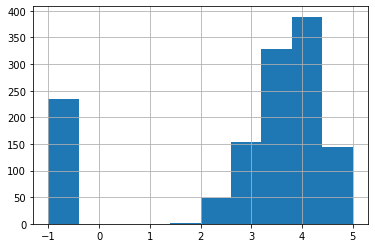

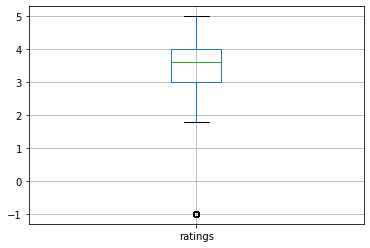

avg_salary


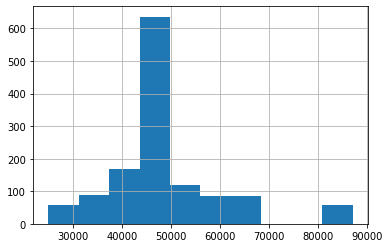

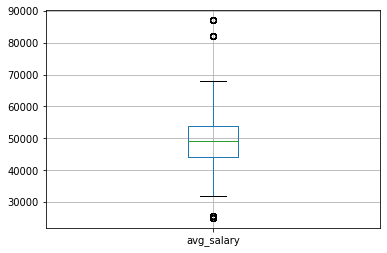

num_comp


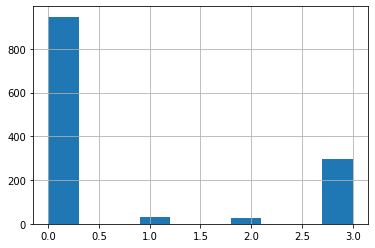

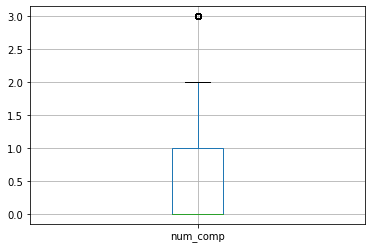

age


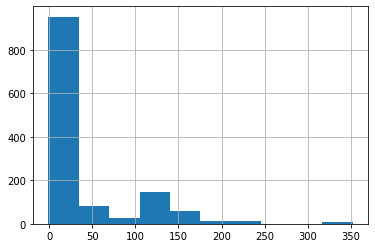

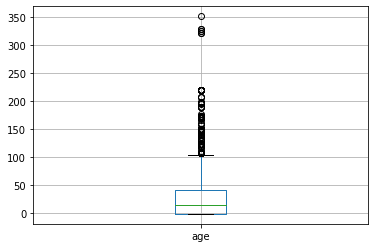

num_languages


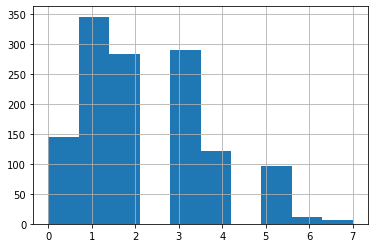

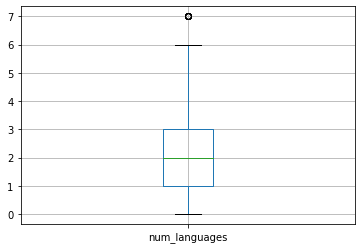

description_len


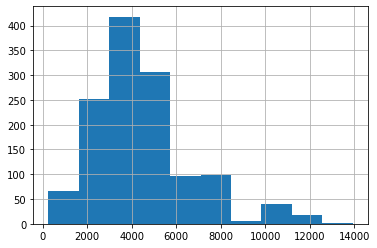

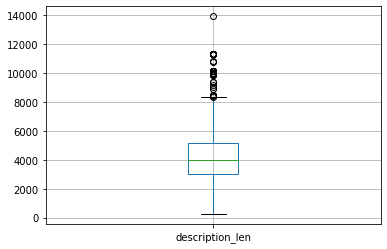

In [16]:
no_plot = ['founded', 'avg_revenue', 'avg_size']
for col in nm_df.columns:
    if col not in no_plot:
        print(col)
        plt.figure()
        nm_df[col].hist()
        plt.show()
        plt.figure()
        nm_df.boxplot(column=col)
        plt.show()

In [17]:
#nm_df = nm_df.drop("founded", axis=1)

In [18]:
# Correlattion table
corr = nm_df.corr()
corr

,ratings,avg_salary,avg_revenue,avg_size,founded,num_comp,age,num_languages,description_len
ratings,1.000000,-0.015298,0.050492,0.388365,0.596688,0.296246,0.302363,-0.064382,0.144064
avg_salary,-0.015298,1.000000,-0.016082,-0.038787,-0.040160,-0.034362,-0.027589,-0.002764,-0.025651
avg_revenue,0.050492,-0.016082,1.000000,0.142649,0.032782,0.039579,0.100215,0.030906,0.026156
avg_size,0.388365,-0.038787,0.142649,1.000000,0.369630,0.626233,0.616499,-0.072233,0.177982
founded,0.596688,-0.040160,0.032782,0.369630,1.000000,0.303052,0.367690,-0.064308,0.238329
num_comp,0.296246,-0.034362,0.039579,0.626233,0.303052,1.000000,0.432185,-0.089149,0.114318
age,0.302363,-0.027589,0.100215,0.616499,0.367690,0.432185,1.000000,-0.047702,0.189465
num_languages,-0.064382,-0.002764,0.030906,-0.072233,-0.064308,-0.089149,-0.047702,1.000000,0.057334
description_len,0.144064,-0.025651,0.026156,0.177982,0.238329,0.114318,0.189465,0.057334,1.000000


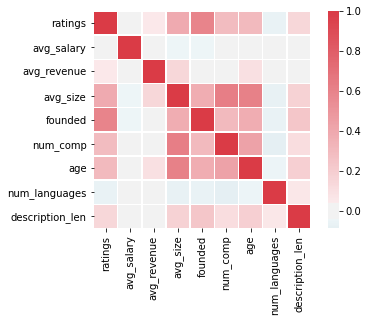

In [19]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, square=True, linewidth=.5, center=0)

In [20]:
# Catagorical columns
catagoric_cols = list(col for col in list(df.columns) if col not in numeric_cols)

In [21]:
# Dataframe of all catagorical data
cat_df = df[catagoric_cols]
cat_df.head()

,Job Title,Job Description,Location,Headquarters,seniority,company_name,location_city,hq_city,languages,ownership,industry,sector,competitors,role
0,Data Scientist - ZISHI Adaptive,"Company DescriptionIn just over 15 years, OSTC...","Bromley, England","London, United Kingdom",junior,OSTC UK,Bromley,London,"[python, excel, sql, aws, hadoop]",private,[Brokerage Services],[Finance],"[J.P. Morgan, XTB, Mandara]",ds
1,"Data Scientist, Digital",The detailsNewton is a high growth and success...,"Wideopen, England","Oxford, United Kingdom",junior,Newton Europe,Wideopen,Oxford,"[python, sql]",private,[Consulting],[Business Services],[-1],ds
2,Data Scientist,Imagine introducing the next generation of tec...,"London, England","London, United Kingdom",junior,G-Research,London,London,"[python, sql, spark]",private,"[Computer Hardware, Software]",[Information Technology],[-1],ds
3,Data Scientist,"Data ScientistCambridge UK, Gaithersburg, Goth...","Cambridge, England","Cambridge, United Kingdom",junior,AstraZeneca,Cambridge,Cambridge,[],public,"[Biotech, Pharmaceuticals]","[Biotech, Pharmaceuticals]","[Roche, GlaxoSmithKline, Novartis]",ds
4,Senior Data Scientist,About UsWe want to help small businesses win. ...,"London, England","London, United Kingdom",senior,Funding Circle UK,London,London,"[python, excel, sql, r ]",private,[Lending],[Finance],"[LendingClub, OnDeck, Bond Street]",ds


In [22]:
# Remove dictionaries and list
# Remove large text fields and pre-derived fields
cat_df = cat_df.drop(["Job Description","Job Title","Location",
                     "Headquarters","languages","industry","sector",
                     "competitors"], axis=1)

In [23]:
cat_df.head()

,seniority,company_name,location_city,hq_city,ownership,role
0,junior,OSTC UK,Bromley,London,private,ds
1,junior,Newton Europe,Wideopen,Oxford,private,ds
2,junior,G-Research,London,London,private,ds
3,junior,AstraZeneca,Cambridge,Cambridge,public,ds
4,senior,Funding Circle UK,London,London,private,ds


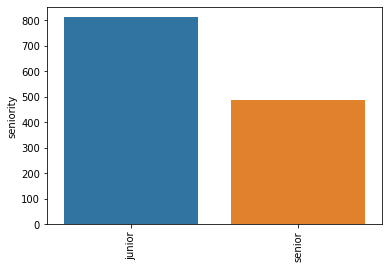

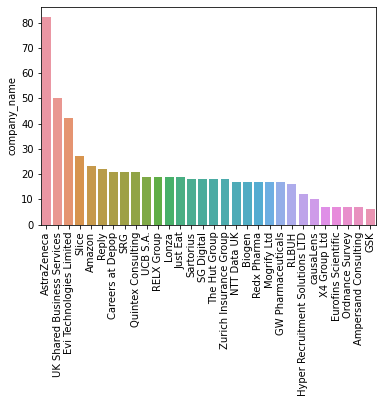

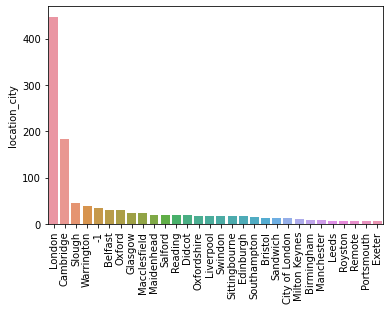

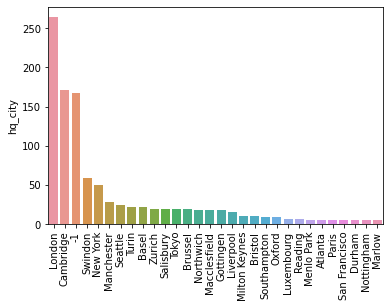

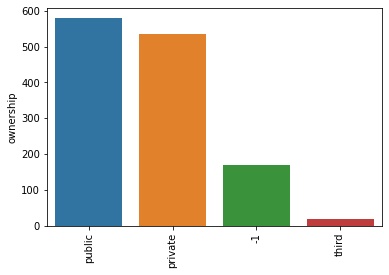

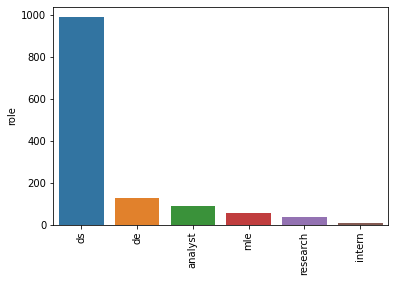

In [24]:
for col in cat_df.columns:
    plt.figure()
    cat_count = cat_df[col].value_counts()[0:30]
    chart = sns.barplot(x=cat_count.index, y=cat_count)
    chart.set_xticklabels(chart.get_xticklabels(),
                         rotation=90)
    plt.show()

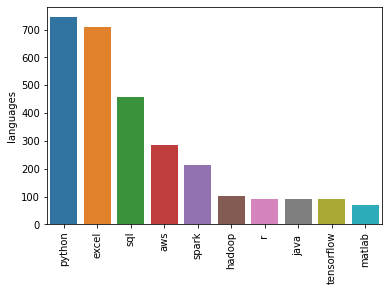

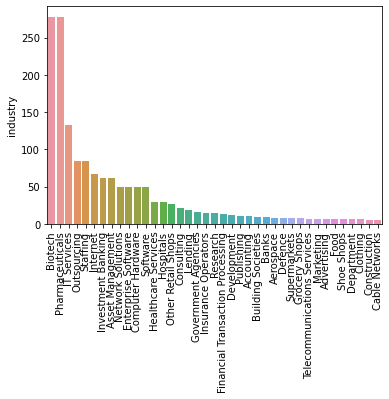

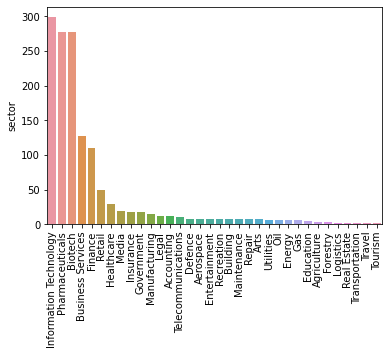

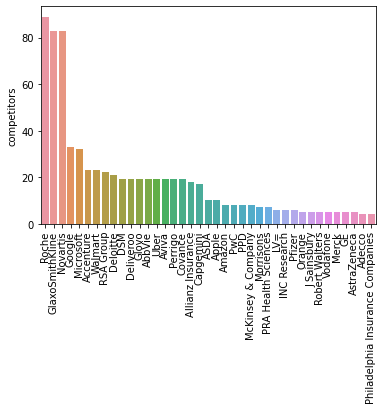

In [25]:
for col in ["languages","industry","sector","competitors"]:
    plt.figure()
    cat_count = df.explode(col)[col].value_counts()[0:40]
    if '-1' in cat_count.index:
        cat_count = cat_count.drop('-1', axis=0)
    chart = sns.barplot(x=cat_count.index, y=cat_count)
    chart.set_xticklabels(chart.get_xticklabels(),rotation=90)
    plt.show()

In [26]:
pd.pivot_table(df, index=['seniority','role'], values='avg_salary').sort_values(by='avg_salary', ascending=False)

avg_salary
seniority role                  
senior    de        53326.923077
junior    mle       50750.000000
          ds        50329.371817
senior    ds        49588.750000
          analyst   49518.518519
junior    research  47500.000000
          de        47321.782178
senior    research  47000.000000
junior    analyst   46725.806452
senior    mle       45793.103448
junior    intern    43500.000000
senior    intern    33500.000000

In [27]:
# Salary by revenue
#pd.pivot_table(df[df.role=='ds'], index=['avg_revenue'], values='avg_salary').sort_values(by='avg_salary', ascending=False)

In [28]:
# Salary by rating
#pd.pivot_table(df[df.role=='ds'], index=['ratings'], values='avg_salary').sort_values(by='avg_salary', ascending=False)

In [29]:
# Salary by industry
#pd.pivot_table(df[df.role=='ds'].explode('industry'), index=['industry'], values='avg_salary').sort_values(by='avg_salary', ascending=False)

In [30]:
# Salary by Sector
#pd.pivot_table(df[df.role=='ds'].explode('sector'), index=['sector'], values='avg_salary').sort_values(by='avg_salary', ascending=False)

In [31]:
# Salary by num_comp
#pd.pivot_table(df[df.role=='ds'], index=['num_comp'], values='avg_salary').sort_values(by='avg_salary', ascending=False)

In [32]:
# Salary by each Language
#pd.pivot_table(df[df.role=='ds'].explode('languages'), index=['languages'], values='avg_salary').sort_values(by='avg_salary', ascending=False)

In [33]:
# Salary by ownership
#pd.pivot_table(df[df.role=='ds'], index=['ownership'], values='avg_salary').sort_values(by='avg_salary', ascending=False)

In [34]:
for col in catagoric_cols:
    print(col)
    try: 
        print(pd.pivot_table(df[df.role=='ds'], index=col, values='avg_salary').sort_values(by='avg_salary', ascending=False))
    except:
        print(pd.pivot_table(df[df.role=='ds'].explode(col), index=col, values='avg_salary').sort_values(by='avg_salary', ascending=False))

Job Title
                                                      avg_salary
Job Title                                                       
BIG DATA ARCHITECT                                  87000.000000
Applied Scientist - Information Retrieval and N...  87000.000000
Clinical Development Scientist - Oncology Haema...  87000.000000
Chief Data Scientist (AI, Data Science)             87000.000000
Chemical Development Scientist                      87000.000000
Lead Scientist - Next Generation Sequencing         87000.000000
Data Platform Software Engineer                     87000.000000
Bioinformatics Data Manager                         87000.000000
Digital Scientist, Associate Director, Oncology...  87000.000000
Computational Genetics Scientist                    87000.000000
Senior Development Scientist                        87000.000000
Senior Organizational Development Scientist         87000.000000
Head of Data Strategy (remote working)              87000.000000
Software Develo

        avg_salary
role              
ds    50029.828109


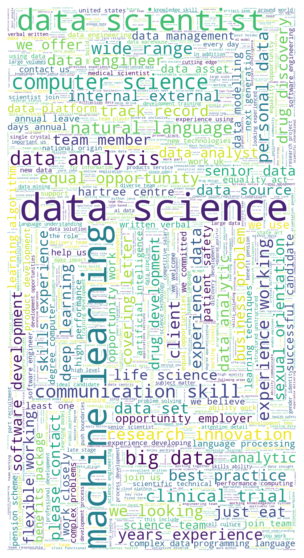

In [44]:
words = " ".join(df['Job Description'])

def punctuation_stop(text):
    """remove punctuation and stop words"""
    filtered = []
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    for w in word_tokens:
        if w not in stop_words and w.isalpha():
            filtered.append(w.lower())
    return filtered


words_filtered = punctuation_stop(words)

text = " ".join([ele for ele in words_filtered])

wc= WordCloud(background_color="white",
              random_state=1, stopwords=STOPWORDS,
              max_words=2000, width=800, height=1500)
wc.generate(text)

plt.figure(figsize=[10,10])
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()